In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

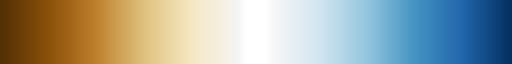

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
import os

In [12]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[1:-2]
# model_list2 = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[18:]
model_list#.extend(model_list2)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [13]:
len(model_list)

30

In [48]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    da['time'] = pd.date_range('1900-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


def extract_composites(detrended_var, nino_anom, base_var, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
    if season_str==None: # for the annual period
        # reorder the vars
        detrended_var = reorder(detrended_var)
        nino_anom = reorder(nino_anom)
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # get the standard devitation of the detrended var
        var_std = detrended_var.groupby('time.year').mean('time').std('year')
        # get the climatology of the base var
        var_clim = base_var.mean('month')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].groupby('time.year').mean('time')).median('year')
        nino = (detrended_var[nino_idx].groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].groupby('time.year').mean('time')).median('year')
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        lin = (enc - lnc)/2
        nonl = (enc + lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        lin_en = xr.where(np.abs(enc) > np.abs(lnc), (lin/enc), 0)
        nonl_en = xr.where(np.abs(enc) > np.abs(lnc), (nonl/enc), 0)
        nature_en = xr.where(np.abs(enc) - np.abs(lnc) > 1, 1, 0)
        #
        lin_ln = xr.where(np.abs(lnc) > np.abs(enc), (-lin/lnc), 0)
        nonl_ln = xr.where(np.abs(lnc) > np.abs(enc), (nonl/lnc), 0)
        nature_ln = xr.where(np.abs(lnc) - np.abs(enc) > 1, -1, 0)
        #
        lin_pc = lin_en + lin_ln
        nonl_pc = nonl_en + nonl_ln
        nature = nature_en + nature_ln
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events
        return {
            'std': var_std,
            'clim': var_clim,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl.where(np.abs(var_corr) >= 0.1, other=0),
            'lin': lin.where(np.abs(var_corr) >= 0.1, other=0),
            'ratio': ratio.where(np.abs(var_corr) >= 0.1, other=0),
            'lin_pc': lin_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nonl_pc': nonl_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nature': nature.where(np.abs(var_corr) >= 0.1, other=np.nan),
        }
    else:
        seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11]}
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # define the season arr
        season_month_arr = seasons_dict[season_str]
        # get the season for the individual cases
        season = detrended_var.time.dt.month.isin(season_month_arr)
        nino_season = detrended_var[nino_idx].time.dt.month.isin(season_month_arr)
        nina_season = detrended_var[nina_idx].time.dt.month.isin(season_month_arr)
        neut_season = detrended_var[neut_idx].time.dt.month.isin(season_month_arr)
        # get the std of detrended var for that season
        var_std = detrended_var.sel(time=season).groupby('time.year').mean('time').std('year')
        # get the climatology of the base var
        var_clim = base_var.sel(month = season_month_arr).mean('month')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')).median('year') 
        nino = (detrended_var[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')).median('year')
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        nonl = (enc + lnc)/2
        lin = (enc - lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        lin_en = xr.where(np.abs(enc) > np.abs(lnc), (lin/enc), 0)
        nonl_en = xr.where(np.abs(enc) > np.abs(lnc), (nonl/enc), 0)
        nature_en = xr.where(np.abs(enc) - np.abs(lnc) > 1, 1, 0)
        #
        lin_ln = xr.where(np.abs(lnc) > np.abs(enc), (-lin/lnc), 0)
        nonl_ln = xr.where(np.abs(lnc) > np.abs(enc), (nonl/lnc), 0)
        nature_ln = xr.where(np.abs(lnc) - np.abs(enc) > 1, -1, 0)
        #
        lin_pc = lin_en + lin_ln
        nonl_pc = nonl_en + nonl_ln
        nature = nature_en + nature_ln
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events for that season
        # season_en = detrended_var[nino_anom > 0].time.dt.month.isin(season_month_arr)
        # season_ln = detrended_var[nino_anom < 0].time.dt.month.isin(season_month_arr)
        # pvalue = spearman_corr3d(nino_anom.expand_dims(dim={'lat':61, 'lon':121}).sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), detrended_var.sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nina = spearman_corr3d(nino_anom[nino_anom < 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom < 0].sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nino = spearman_corr3d(nino_anom[nino_anom > 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom > 0].sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        return {
            'std': var_std,
            'clim': var_clim,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl.where(np.abs(var_corr) >= 0.1, other=0),
            'lin': lin.where(np.abs(var_corr) >= 0.1, other=0),
            'ratio': ratio.where(np.abs(var_corr) >= 0.1, other=0),
            'lin_pc': lin_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nonl_pc': nonl_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nature': nature.where(np.abs(var_corr) >= 0.1, other=np.nan),
        }

In [51]:
def calc_data_res(model_list, season):
    i = 1
    base_loc = '/scratch/ob22/as8561/data/'
    threshold_arr = []
    for model in model_list:
        # get all the data
        precip = xr.open_dataset(base_loc + f'preproc/{model}/precip.nc').precip
        precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
        precip = precip.sortby(precip.lon)
        nino = xr.open_dataset(base_loc + f'preproc/{model}/nino.nc').nino
        precip_base = xr.open_dataset(base_loc + f'preproc/{model}/base_precip.nc').pr
        precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
        precip_base = precip_base.sortby(precip_base.lon)
        # get the weights
        weights = np.cos(np.deg2rad(precip.lat))
        weights.name = 'weights'
        # get nino threshold
        threshold = float(nino.std())
        # mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D(precip, wrap_lon=False, drop=False)
        res = extract_composites(precip, nino, precip_base, \
                                          season_str=season, threshold=threshold, min_duration=6, rolling_period=5)
        threshold_arr.append(threshold)
        for key in res.keys():
            os.system(f'mkdir -p {base_loc}' + f'proc/{model}/{season}')
            np.save(base_loc + f'proc/{model}/{season}/' + key, res[key])
        print(f'Completed {i}/{len(model_list)}')
        i += 1
    print('Complete')
    return threshold_arr

In [52]:
threshold_ann = calc_data_res(model_list, season=None)

Completed 1/30
Completed 2/30
Completed 3/30
Completed 4/30
Completed 5/30
Completed 6/30
Completed 7/30
Completed 8/30
Completed 9/30
Completed 10/30
Completed 11/30
Completed 12/30
Completed 13/30
Completed 14/30
Completed 15/30
Completed 16/30
Completed 17/30
Completed 18/30
Completed 19/30
Completed 20/30
Completed 21/30
Completed 22/30
Completed 23/30
Completed 24/30
Completed 25/30
Completed 26/30
Completed 27/30
Completed 28/30
Completed 29/30
Completed 30/30
Complete


In [ ]:
threshold_djf = calc_data_res(model_list, season='djf')

Completed 1/30
Completed 2/30
Completed 3/30
Completed 4/30
Completed 5/30
Completed 6/30
Completed 7/30
Completed 8/30
Completed 9/30
Completed 10/30
Completed 11/30


In [ ]:
threshold_mam = calc_data_res(model_list, season='mam')

In [ ]:
threshold_jja = calc_data_res(model_list, season='jja')

In [ ]:
threshold_son = calc_data_res(model_list, season='son')

In [12]:
def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def extract_composites(detrended_var, nino_anom, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
    if season_str==None: # for the annual period
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # get the standard devitation of the detrended var
        var_std = detrended_var.groupby('time.year').mean('time').std('year')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].groupby('time.year').mean('time')).median('year')
        nino = (detrended_var[nino_idx].groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].groupby('time.year').mean('time')).median('year')
        # calc nino_change
        nino_change = (nino-neut)
        nina_change = (nina-neut)
        # calc index
        nonlinearity = (nino_change + nina_change)/2 # TODO : ask about this
        linearity = (nino_change - nina_change)/2
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events
        return {
            'std': var_std,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'nino_change': nino_change,
            'nina_change': nina_change,
            'nonlinearity': nonlinearity,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            'linearity': linearity,
            # 'nature_nino': nature_nino,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            # 'nature_nina': nature_nina,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            # 'nonlinearity': nonlinearity.where(pvalue <= 0.05),
            # 'nature_nino': nature_nino.where(pvalue <= 0.05),
            # 'nature_nina': nature_nina.where(pvalue <= 0.05),
            # 'neut_index': neut_idx,
            # 'nino_index': nino_idx,
            # 'nina_index': nina_idx,
            # 'pvalue_nino': pvalue_nino,
            # 'pvalue_nina': pvalue_nina,
        }
    else:
        seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11]}
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # define the season arr
        season_month_arr = seasons_dict[season_str]
        # get the season for the individual cases
        season = detrended_var.time.dt.month.isin(season_month_arr)
        nino_season = detrended_var[nino_idx].time.dt.month.isin(season_month_arr)
        nina_season = detrended_var[nina_idx].time.dt.month.isin(season_month_arr)
        neut_season = detrended_var[neut_idx].time.dt.month.isin(season_month_arr)
        # get the std of detrended var for that season
        var_std = detrended_var.sel(time=season).groupby('time.year').mean('time').std('year')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')).median('year') 
        nino = (detrended_var[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')).median('year')
        # calc nino_change
        nino_change = (nino-neut)
        nina_change = (nina-neut)
        # calc index
        nonlinearity = (nino_change + nina_change)/2 # TODO : ask about this
        linearity = (nino_change - nina_change)/2 # TODO : ask about this
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events for that season
        # season_en = detrended_var[nino_anom > 0].time.dt.month.isin(season_month_arr)
        # season_ln = detrended_var[nino_anom < 0].time.dt.month.isin(season_month_arr)
        # pvalue = spearman_corr3d(nino_anom.expand_dims(dim={'lat':61, 'lon':121}).sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), detrended_var.sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nina = spearman_corr3d(nino_anom[nino_anom < 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom < 0].sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nino = spearman_corr3d(nino_anom[nino_anom > 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom > 0].sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        return {
            'std': var_std,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'nino_change': nino_change,
            'nina_change': nina_change,
            'nonlinearity': nonlinearity,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            'linearity': linearity,
            # 'nature_nino': nature_nino,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            # 'nature_nina': nature_nina,#.where((pvalue_nino <= 0.05) | (pvalue_nina <= 0.05)),
            # 'nonlinearity': nonlinearity.where(pvalue <= 0.05),
            # 'nature_nino': nature_nino.where(pvalue <= 0.05),
            # 'nature_nina': nature_nina.where(pvalue <= 0.05),
            # 'neut_index': neut_idx,
            # 'nino_index': nino_idx,
            # 'nina_index': nina_idx,
            # 'pvalue_nino': pvalue_nino,
            # 'pvalue_nina': pvalue_nina,
        }

In [138]:
def extract_scatters(detrended_var, nino_anom, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
    weights = np.cos(np.deg2rad(detrended_var.lat))
    weights.name = 'weights'
    if season_str==None: # for the annual period
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # get the corr
        xxxx = nino_anom.groupby('time.year').mean('time')
        yyyy = detrended_var.weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')
        corr = get_corr_1d(xxxx, yyyy)
        pval = get_pval_1d(xxxx, yyyy)
        # get std
        yy_std = detrended_var.weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time').std('year')
        xx_std = nino_anom.groupby('time.year').mean('time').std('year')
        # get the nino_event_months
        ninoy = detrended_var[nino_idx].weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        ninay = detrended_var[nina_idx].weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        neuty = detrended_var[neut_idx].weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        # ninox = nino_anom[nino_idx].groupby('time.year').mean('time')/xx_std
        # ninax = nino_anom[nina_idx].groupby('time.year').mean('time')/xx_std
        # neutx = nino_anom[neut_idx].groupby('time.year').mean('time')/xx_std
        enc = ninoy.median('year') - neuty.median('year')
        lnc = ninay.median('year') - neuty.median('year')
        nonl = (enc+lnc)/2
        # linear = (enc - lnc)/2
        return enc, lnc, nonl
    else:
        seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11], 'sondjf':[9,10,11,12,1,2]}
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # define the season arr
        season_month_arr = seasons_dict[season_str]
        # get the season for the individual cases
        season = nino_anom.time.dt.month.isin(season_month_arr)
        nino_season = nino_anom[nino_idx].time.dt.month.isin(season_month_arr)
        nina_season = nino_anom[nina_idx].time.dt.month.isin(season_month_arr)
        neut_season = nino_anom[neut_idx].time.dt.month.isin(season_month_arr)
        # get std
        yy_std = detrended_var.sel(time = season).weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time').std('year')
        xx_std = nino_anom.sel(time = season).groupby('time.year').mean('time').std('year')
        # get the corr
        xxxx = nino_anom.sel(time = season).groupby('time.year').mean('time')
        yyyy = detrended_var.sel(time = season).weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')
        corr = get_corr_1d(xxxx, yyyy)
        pval = get_pval_1d(xxxx, yyyy)
        # get the nino_event_months
        neuty = detrended_var[neut_idx].sel(time=neut_season).weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        ninoy = detrended_var[nino_idx].sel(time=nino_season).weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        ninay = detrended_var[nina_idx].sel(time=nina_season).weighted(weights).mean(('lat', 'lon')).groupby('time.year').mean('time')#/yy_std
        # neutx = nino_anom[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')/xx_std
        # ninox = nino_anom[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')/xx_std
        # ninax = nino_anom[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')/xx_std
        enc = ninoy.median('year') - neuty.median('year')
        lnc = ninay.median('year') - neuty.median('year')
        nonl = (enc+lnc)/2
        # linear = (enc - lnc)/2
        # return {
        #     'ninoy': ninoy,
        #     'ninox': ninox,
        #     'ninay': ninay,
        #     'ninax': ninax,
        #     'neuty': neuty,
        #     'neutx': neutx,
        #     'xx_std': xx_std,
        #     'yy_std': yy_std,
        #     'corr': corr,
        #     'pval': pval,
        #     'enc': enc,
        #     'lnc': lnc,
        #     'nonl': nonl,
        #     'linear': linear
        # }
        return enc, lnc, nonl

In [129]:
import regionmask

In [155]:
def calc_model_res(model_list):
    nonl_arr = []
    enc_arr = []
    lnc_arr = []
    i = 1
    base_loc = '/scratch/ob22/as8561/data/preproc/'
    for model in model_list:
        # get all the data
        precip = xr.open_dataset(base_loc + f'{model}/precip.nc').precip
        precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
        precip = precip.sortby(precip.lon)
        nino = xr.open_dataset(base_loc + f'{model}/nino.nc').nino
        # precip_base = xr.open_dataset(base_loc + f'{model}/base_precip.nc').pr
        # precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
        # precip_base = precip_base.sortby(precip_base.lon)
        # ann_clim = precip_base.mean('month')
        # djf_clim = precip_base.sel(month = [12,1,2]).mean('month')
        # mam_clim = precip_base.sel(month = [3,4,5]).mean('month')
        # jja_clim = precip_base.sel(month = [6,7,8]).mean('month')
        # son_clim = precip_base.sel(month = [9,10,11]).mean('month')
        # get the weights
        # weights = np.cos(np.deg2rad(precip.lat))
        # weights.name = 'weights'
        # get nino threshold
        threshold = float(nino.std())
        mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(precip, wrap_lon=False, drop=False)
        enc, lnc, nonl = extract_scatters(precip.where(mask.isel(region = 225)), nino, season_str='djf', threshold=threshold, min_duration=6, rolling_period=5)
        nonl_arr.append(float(nonl))
        enc_arr.append(float(enc))
        lnc_arr.append(float(lnc))
        print(f'Completed {i}/{len(model_list)}')
        i += 1
    print('Complete')
    return enc_arr, lnc_arr, nonl_arr

In [156]:
enc, lnc, nonl = calc_model_res(model_list)

Completed 1/30
Completed 2/30
Completed 3/30
Completed 4/30
Completed 5/30
Completed 6/30
Completed 7/30
Completed 8/30
Completed 9/30
Completed 10/30
Completed 11/30
Completed 12/30
Completed 13/30
Completed 14/30
Completed 15/30
Completed 16/30
Completed 17/30
Completed 18/30
Completed 19/30
Completed 20/30
Completed 21/30
Completed 22/30
Completed 23/30
Completed 24/30
Completed 25/30
Completed 26/30
Completed 27/30
Completed 28/30
Completed 29/30
Completed 30/30
Complete


In [67]:
ann_arr = []
for val in model_res:
    nn = float(val['ann'])
    ann_arr.append(nn)
for val in model_res2:
    nn = float(val['ann'])
    ann_arr.append(nn)

In [68]:
djf_arr = []
for val in model_res:
    nn = float(val['djf'])
    djf_arr.append(nn)
for val in model_res2:
    nn = float(val['djf'])
    djf_arr.append(nn)

In [69]:
mam_arr = []
for val in model_res:
    nn = float(val['mam'])
    mam_arr.append(nn)
for val in model_res2:
    nn = float(val['mam'])
    mam_arr.append(nn)

In [70]:
jja_arr = []
for val in model_res:
    nn = float(val['jja'])
    jja_arr.append(nn)
for val in model_res2:
    nn = float(val['jja'])
    jja_arr.append(nn)

In [71]:
son_arr = []
for val in model_res:
    nn = float(val['son'])
    son_arr.append(nn)
for val in model_res2:
    nn = float(val['son'])
    son_arr.append(nn)

In [72]:
len(model_list)

28

In [145]:
# data_dict = dict(model=model_list, ann=ann_arr, djf=djf_arr, mam=mam_arr, jja=jja_arr, son=son_arr)

# df = pd.DataFrame(data_dict)

In [157]:
data_dict = dict(model=model_list, nonl = nonl, enc = enc, lnc=lnc)

df = pd.DataFrame(data_dict)

In [89]:
# mme_row = dict(model = 'MME', ann = df['ann'].mean(), djf = df['djf'].mean(), mam = df['mam'].mean(), jja = df['jja'].mean(), son = df['son'].mean())
obs_row = dict(model = 'OBS', ann = 0.675306, djf = 0.267705, mam = 0.740307, jja = 0.104930, son = 0.422413)
rean_row = dict(model = 'REAN', ann = 0.549611, djf = 0.276824, mam = 0.7499755, jja = 0.103978, son = 0.507376)

In [101]:
# df = df.append(mme_row, ignore_index=True)
df = df.append(obs_row, ignore_index=True)
df = df.append(rean_row, ignore_index=True)

In [158]:
df['lin'] = (df['lnc'] - df['enc'])/2

In [159]:
df['rat'] = (df['nonl']/df['lin'])

In [161]:
df

,model,nonl,enc,lnc,lin,rat
0,ACCESS-CM2,6.727170,-2.646601,16.100940,9.373771,0.717659
1,ACCESS-ESM1-5,-4.533474,-18.707844,9.640897,14.174370,-0.319836
2,AWI-CM-1-1-MR,-9.665399,-23.285479,3.954681,13.620080,-0.709643
3,CESM2,7.670537,-17.732762,33.073837,25.403300,0.301950
4,CESM2-WACCM,-0.374129,-21.075962,20.327705,20.701834,-0.018072
5,CMCC-CM2-SR5,-14.953251,-38.654581,8.748079,23.701330,-0.630903
6,CNRM-CM6-1,0.368126,-6.673553,7.409806,7.041680,0.052278
7,CNRM-CM6-1-HR,6.863037,1.827338,11.898735,5.035698,1.362877
8,CNRM-ESM2-1,4.560799,-3.867661,12.989258,8.428459,0.541119
9,CanESM5,-4.291256,-21.040256,12.457744,16.749000,-0.256210


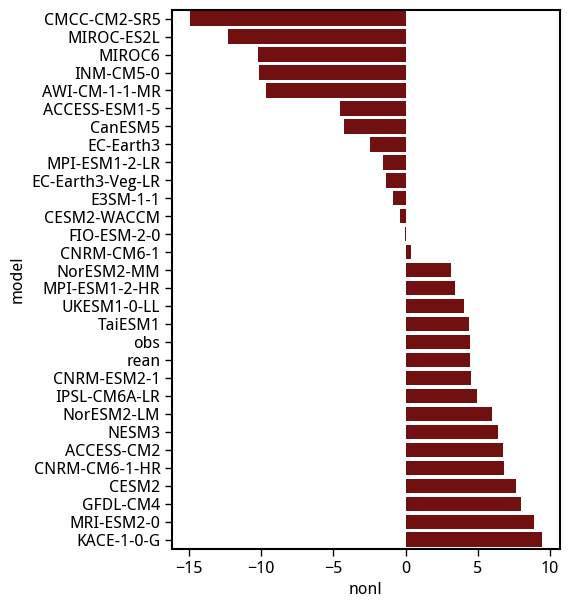

In [163]:
plt.figure(figsize=(5,7))
sns.barplot(data = df.sort_values('nonl'), y='model', x = 'nonl', color='maroon')
plt.savefig('./PhD/prelim_tasks/images/pres/model_perf.png', dpi=300, bbox_inches='tight')